Practical 1: The goal of this practical session is to build backprop from scratch and a small neural network (MLP).

Please return your notebook right at the end of the session.  You then have a week to return an updated version.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

In [3]:
# code to display a network - do not modify this cell
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    
    out._backward = _backward
    return out

  def __mul__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other -1)) * out.grad

    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other 

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self): # TODO ex.3
    t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t ** 2) * out.grad

    out._backward = _backward
    return out
    
  def exp(self): # ex.6
    t = math.exp(self.data)
    out = Value(t, (self, ), 'exp')

    def _backward():
      self.grad += t * out.grad

    out._backward = _backward
    return out
    
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [5]:
# Exercise 1: fill in __add__ and __mul__ in the Value class to enable the following function. You should get -8.0 as a result.
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L

print(lol().data)

-8.0


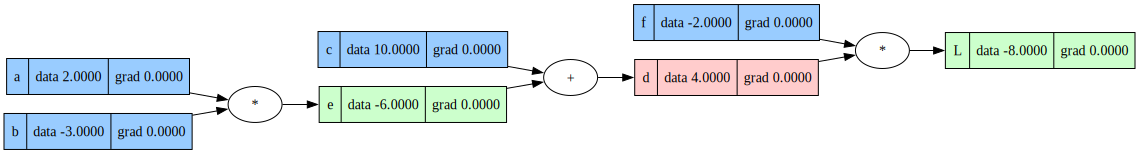

In [6]:
draw_dot(lol())

In [7]:
# Exercise 2: use the lol_grad() function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

In [8]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
# dL/df = 4.0
# etc.
lol_grad()


-1.9999999999953388


In [9]:
# Exercise 3: implement the function tanh() in the Value class and build the following network
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
print(o.data)


0.6043677771171636


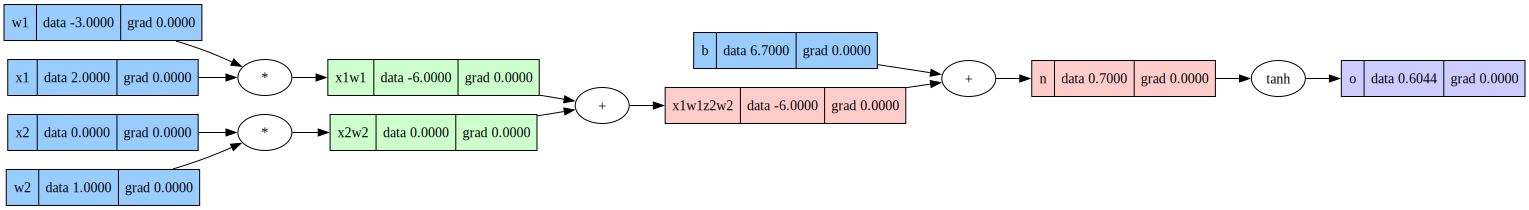

In [10]:
# o.data should be 0.6044
draw_dot(o)

0.7071067811865476
0.9999999999999998
0.0
-1.4999999999999996
0.4999999999999999


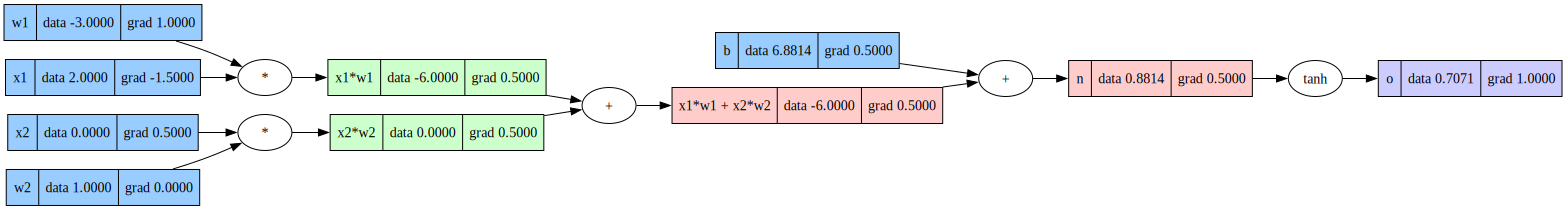

In [11]:
# Exercise 4: Implement the backward() function in each Value's operator: __add__, __mul__, __tanh__ and assign it to _backward
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward()

print(o.data)
print(w1.grad)
print(w2.grad)
print(x1.grad)
print(x2.grad)

draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

In [12]:
# Exercise 5: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. 
# Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?

# Answer: 
# We use "self.grad += " instead of `self.grad =` because a "Value" can contribute
# to the output through multiple paths in the computation graph.

# Example
a = Value(2.0)
b = a + a
b.backward
print(b.data)

# Here, "a" affects "b" twice, so its gradient must be accumulated.

4.0


0.7071067811865477
-1.5
0.5
1.0
0.0


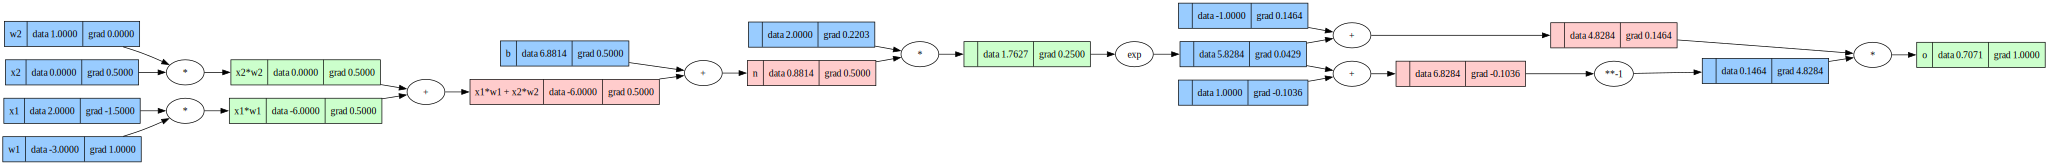

In [13]:
# Exercise 6: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = ... (no tanh allowed)
# ----
o.label = 'o'
o.backward()

print(o.data)
print(x1.grad)  
print(x2.grad) 
print(w1.grad)  
print(w2.grad)  

draw_dot(o)

In [14]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [15]:
# Exercise 7: Let's build an MLP based on the Value class.  Fill in the Neuron, Layer and MLP classes.

# Answer:

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
      self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
      return [n(x) for n in self.neurons]

  def parameters(self):
      params = []
      for n in self.neurons:
          params.extend(n.parameters())
      return params


class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) == 1 else x

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params


In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.31215603306998974)

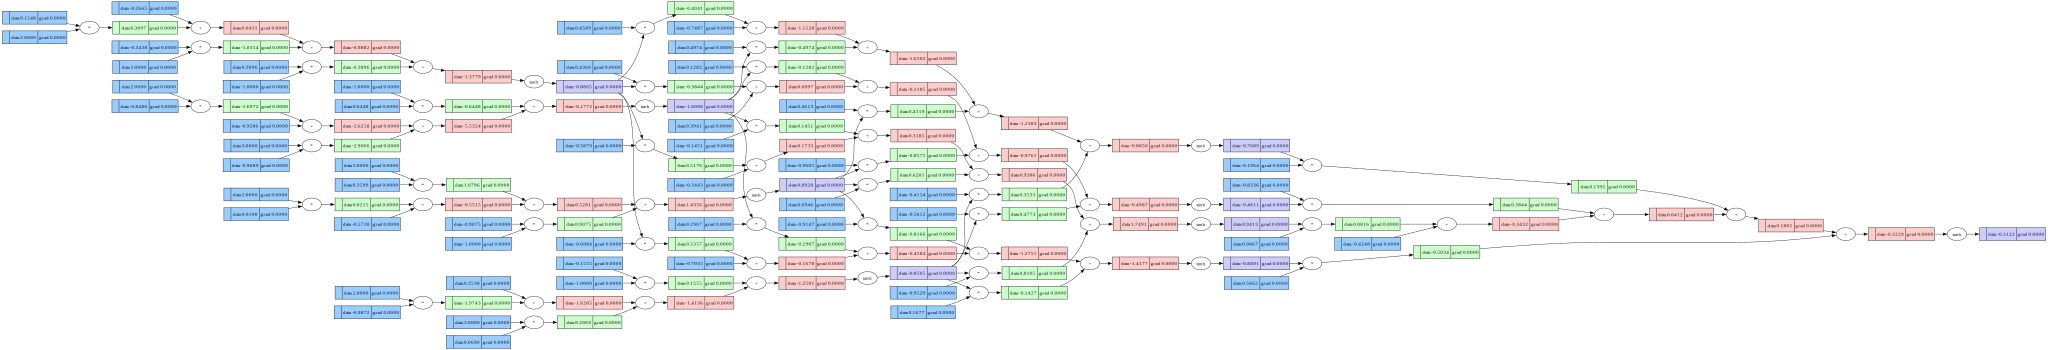

In [17]:
draw_dot(n(x))

In [18]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [19]:
len(n.parameters())

41

In [20]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.31215603306998974),
 Value(data=-0.8966179517655062),
 Value(data=-0.7853701949145488),
 Value(data=-0.34021284409969726)]

In [21]:
loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)])
loss

Value(data=3.574677723739949)

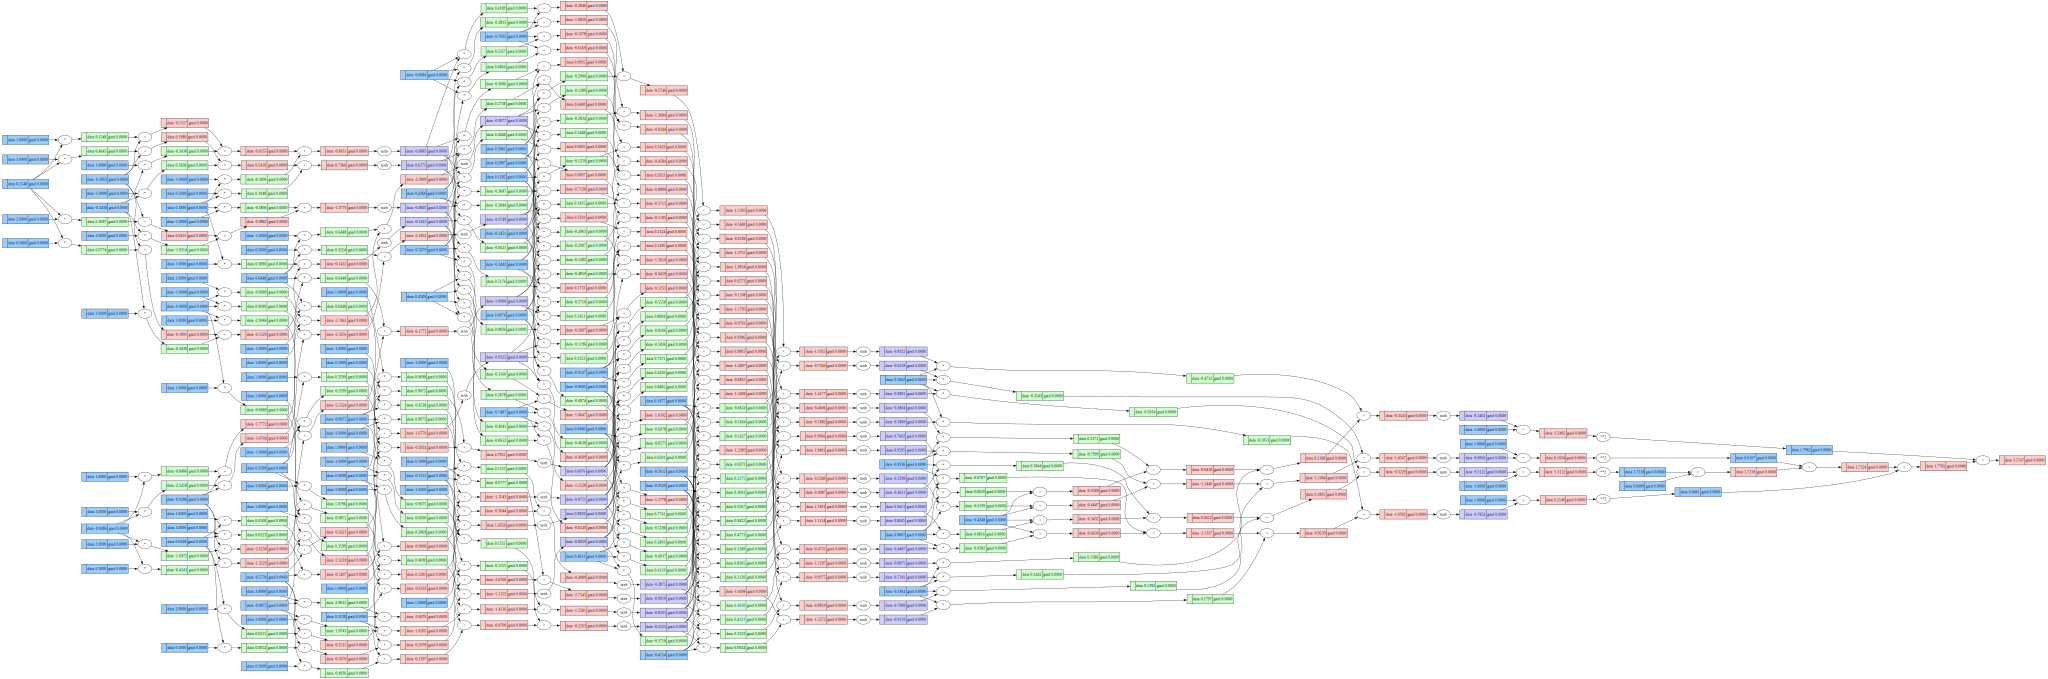

In [22]:
# see how a simple MLP can yield a complex graph already
draw_dot(loss)

In [23]:
# Exercise 8: write a training loop
lr = 0.01
for k in range(20):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum((yhat - y)**2 for yhat, y in zip(ypred, ys)) # MSE between ypred and ground-truth
    #backward pass 
    loss.backward()
    # update
    for p in n.parameters():
        p.data -= lr * p.grad
        p.grad = 0.0
    print(k, loss.data)

0 3.574677723739949
1 2.391994883422923
2 1.5685863536722446
3 1.1030727307458328
4 0.8421321940979174
5 0.6845236303636602
6 0.5811786917248459
7 0.5084963226098049
8 0.4544177301923758
9 0.4123482329465556
10 0.37845119202507405
11 0.35037087492950125
12 0.3265915075257575
13 0.3060970537248501
14 0.28818149326015663
15 0.2723383600648723
16 0.2581939411631887
17 0.24546549443323248
18 0.23393431244545382
19 0.22342787467764114


In [24]:
# Exercise 9: why do you need to reset the grads to zero at every training step?  Answer as a comment in this cell.

# Answer:
# We must reset gradients to zero at every training step because gradients
# are ACCUMULATED during backpropagation.

# If we do not reset them, the gradients from previous iterations will be
# added to the new gradients, making the update incorrect.

In [25]:
# Exercise 10 (*): try to approximate the n^2 function with a 2-layer MLP.  why is it so hard?

# Answer: 
# Approximating x^2 with a small MLP is hard because:
# - tanh saturates and has vanishing gradients
# - x^2 requires multiplicative structure
# - the function grows unbounded while tanh is bounded
# - MLPs approximate functions locally and extrapolate poorly

In [27]:
# Example
# Dataset
num = 50
xs = [[a/num] for a in range(-num, num)]
ys = [b[0]**2 for b in xs]
n = MLP(1,[8,8,1])
len(n.parameters())

97

In [ ]:
# Training
lr = 0.001
for k in range(200):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum([(a-b)**2 for(a,b) in zip(ypred, ys)])
    #backward pass 
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update
    for p in n.parameters():
        p.data -= lr * p.grad
    print(k, loss.data)

# 1min

0 92.55971363087878
1 16.101693387740127
2 8.03360368790016
3 4.29395833319321
4 3.800819949642853
5 4.128506231515565
6 4.640013775600116
7 6.572810557072604
8 6.6931130316208245
9 10.879115731240597
10 6.364722676414925
11 10.149043836060319
12 6.10697724453429
13 9.566271556917616
14 5.824675281265332
15 8.948936324336605
16 5.560759624814057
17 8.376619571396462
18 5.298625447238723
19 7.821801694859191
20 5.042364472757554
21 7.2929149597789955
22 4.791118372020883
23 6.78906819790789
24 4.545206208902838
25 6.310793160523536
26 4.305007610787729
27 5.858251510703306
28 4.071010038922257
29 5.431419901835984
30 3.8437549080884006
31 5.030093829845729
32 3.6237956837550027
33 4.653900684389427
34 3.411663935535999
35 4.302315326624883
36 3.2078428603768327
37 3.9746774894845895
38 3.0127477526584086
39 3.6702103761849854
40 2.8267127858793137
41 3.3880398371284115
42 2.649983370765438
43 3.1272135409533988
44 2.482713286439639
45 2.886719620405195
46 2.3249657515589157
47 2.6655043

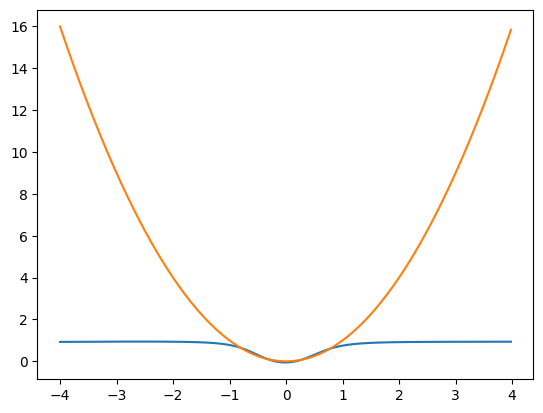

In [29]:
xs = [a/50 for a in range(-200,200)]
ys = [n([x]).data for x in xs]
yg = [x**2 for x in xs]
plt.plot(xs, ys)
plt.plot(xs, yg)
plt.show()